# 🧠 08. Orchestration 1: Model Selection

### 🌍 Why Model Selection Matters

In real-world intelligent systems — from **smart glasses** and **autonomous assistants** to **customer support bots** and **game AIs** — every interaction comes with a trade-off:

* Should we use a **small local model** for instant responses,
* or a **large cloud-based model** for deep reasoning and nuanced understanding?

The answer depends on the **context** — the *prompt*, the *time pressure*, and the *importance of correctness*. This is where **model selection** comes in. Instead of relying on one fixed model, an *agentic system* dynamically chooses *which model* to invoke for each input. Think of it as a **meta-brain** — one that learns when to think fast 🏎️ and when to think deep 🧘‍♂️.

### 🧪 Formulation

The idea of model selection is basically identifying and leveraging profiling and predictors to make informed decisions on which LLM is apt for a given input prompt. We use simple embeddings models such as [EmbeddingGemma](https://deepmind.google/models/gemma/embeddinggemma/) that provide a dense vector representation for a given prompt. Using such vectors as inputs, we train simple regression models, such as [XGBoost](https://www.geeksforgeeks.org/machine-learning/xgboost/), to predict how mission-critical or time-critical an input is. 

* An example of a mission critical instruction is "Tell me step-by-step on how to administer insulin". This requires a high response quality, and achieving low-latency is not super important here. 
* An example of a time critical instruction is "A bee stung me, what to do?". Low-latency is of the essence here!

Suppose we are building a smart-glass application, we want to be able to predict first how mission critical or time critical the input instruction is before taking an oblivious decision on which LLM to use to generate a response. This is critical because for a time-critical instruction, if we use a slow reasoning model, we might be providing a poor Quality of Service (QoS) to the user. 

Another stage of this is to be able to profile various LLM options (small and large) to identify and predict using regression models, what their response quality or latency is going to be for a given prompt. If we can somehow then calculate QoS as a combination of predicted: response quality, mission criticality, latency and time criticality, then we can identify which LLM can give the highest predicted QoS. This acts as a simple yet effective selection policy to build intelligent agents. For instance, when comparing two models `Qwen3 8B Instruct` and `LiquidAI 8B A1B` we can then predict QoS as:

![image](assets/model_selection.png)

For this fictitious example, we see that the predicted QoS of `LiquidAI 8B A1B` is higher and hence can be used for the given time-critical task as it has lower latency. 

### ⚙️ What We’ll Build

In this tutorial, we’ll design a **Model Selection Orchestrator** that automatically decides the best model for any prompt.
We’ll:
1. **Profile multiple LLMs** (like `gpt-4`, `mistral`, `gemma`) on latency and response quality.
2. **Use an LLM as a judge** to rate response quality from the IHAP benchmark dataset ([Dahoas/instruct-human-assistant-prompt](https://huggingface.co/datasets/Dahoas/instruct-human-assistant-prompt)).
3. **Train simple regressors** that can predict latency and quality from prompt embeddings.
4. **Use another judge model** to score prompts on *time criticality* and *mission criticality*.
5. **Combine all metrics** into a *Quality of Service (QoS)* function to select the optimal model for new inputs.


### 🧩 The Quality-of-Service (QoS) Equation

We’ll formalize the idea of trade-offs between *quality*, *speed*, and *importance* as:

$$
QoS = (\text{Response Quality} \times \text{Mission Criticality}) + (\text{Time Criticality} \times \frac{1}{\text{Latency}})
$$

This formula rewards models that deliver **high-quality** responses when it matters, and **fast** responses when time is critical — just like a real agent deciding whether to “think slow” or “act fast.”


I highly recommend reading this [blog post](https://www.oreilly.com/radar/llm-system-design-and-model-selection/) to learn more. For the formulation we are using here, I'd recommend going through my paper [here](https://dl.acm.org/doi/abs/10.1145/3749483). 


In [1]:
from datasets import load_dataset
import random
import re

random.seed(42)

# Load dataset from Hugging Face
dataset = load_dataset("Dahoas/instruct-human-assistant-prompt")

def extract_prompt(text: str) -> str:
    """Extracts the part between 'Human:' and '\nAssistant:'."""
    match = re.search(r"Human:\s*(.*?)\s*\n\s*Assistant:", text, flags=re.DOTALL)
    if match:
        return match.group(1).strip()
    return text.strip()

# Apply extraction to each example in the training split
ds = [extract_prompt(x["prompt"]) for x in dataset["train"]]
random.shuffle(ds)

ds[:10]

['Where can I find the best deals on airline tickets.',
 'What do you know about Mount Everest.',
 'Help walk me through baking a cake',
 'What holidays are celebrated in [x] country?\n              \n              1',
 'What can I make for my anniversary using the oven I currently have?',
 'What steps can my business take that would help our sustainability?',
 'What channel do I need to be on in order to watch live college football?',
 'How long will frozen ravioli keep in the freezer and be safe to heat up and eat?',
 'Can you provide me some tips for starting a successful business.',
 'How can I make a good cup of coffee at home.']

### ⚙️ Profiling Different LLMs

Before we can *select* the right model for a new prompt, we first need to **understand how each model behaves** —
how fast it is, how good its answers are, and how consistent its quality is across different types of prompts.

This process is called **model profiling**.
Think of it as building a “performance fingerprint” 🕵️‍♀️ for each model in our candidate pool.


### 🧩 What We’ll Measure

For every prompt in our training split, we’ll record:

* **Latency (seconds):** How long the model takes to respond.
* **Response Quality (0–100):** Judged by another stronger model (our *LLM-as-a-judge*).
* **Response Text:** The actual answer returned (for inspection and optional dataset reuse).

These metrics will help us later train lightweight predictors that estimate a model’s expected latency and quality *without needing to query every model again*.


### 🤖 Choice of Candidate Models

We’ll benchmark a diverse but comparable set of **mid-sized models (≈8B parameters)** — ideal for edge or hybrid inference setups like *smart-glasses*, where both performance and speed matter.

| Model                              | Type                          | Strength                               |
| :--------------------------------- | :---------------------------- | :------------------------------------- |
| `qwen/qwen3-vl-8b-instruct`        | Multimodal reasoning          | Balanced reasoning + vision/text       |
| `qwen/qwen3-vl-8b-thinking`        | Chain-of-thought reasoning    | Slower but deeper analytical responses |
| `liquid/lfm2-8b-a1b`               | Lightweight instruction model | Optimized for speed                    |
| `mistralai/ministral-8b`           | Compact Mistral variant       | Very low latency baseline              |
| `meta-llama/llama-3.1-8b-instruct` | General-purpose               | High-quality language understanding    |

We’ll also use **`gpt-4o`** as the **judge model** —
a strong, reliable evaluator that can score each model’s answer for **accuracy, completeness, and clarity**.


### 🧮 How It Works

For each prompt:

1. Query all candidate models.
2. Record the time taken for each response.
3. Pass the result to the **judge model**, which scores the response on a 0–100 scale.
4. Save all metrics into a structured dataset for downstream learning.

Once complete, we’ll have a **profiling dataset** ready for the next step — training regressors to predict latency and quality directly from prompt embeddings.

In [177]:
import time, os
from typing import List, Dict

import pandas as pd
from pydantic import BaseModel, Field
from pydantic_ai import Agent
from tqdm import tqdm
import nest_asyncio
from dotenv import load_dotenv

load_dotenv()
nest_asyncio.apply()

NUM_TRAIN_SAMPLES = 100
DATA_DIR = "data/model_selection"

# Candidate models we want to profile 
CANDIDATE_MODELS = ["openrouter:qwen/qwen3-vl-8b-instruct", 
                    "openrouter:qwen/qwen3-vl-8b-thinking", 
                    "openrouter:liquid/lfm2-8b-a1b", 
                    "openrouter:mistralai/ministral-8b",
                    "openrouter:meta-llama/llama-3.1-8b-instruct"]

# Stronger judge model
JUDGE_MODEL = "openrouter:openai/gpt-4o"

def build_candidate_agent(model_name: str) -> Agent:
    agent = Agent(
        model=model_name,
        system_prompt=(
            "You are an expert assistant. Provide concise, correct, and well-structured answers. "
            "Prefer bullet points when helpful; include equations/code only if needed. Be brief, clear, and safe."
        ),
        model_settings={"temperature": 0.2, "max_tokens": 256}
    )
    return agent

class JudgeScore(BaseModel):
    score: float = Field(..., ge=0, le=100, description="Response quality score on a 0–100 scale.")

JUDGE_RUBRIC = """
You are an expert evaluator. Score an assistant response on a 0–100 scale for overall response quality:
- Faithfulness to the prompt
- Factual correctness
- Completeness and depth
- Clarity, structure, and helpfulness
- Safety (avoid harmful content)

Calibrate with these exemplars:

[Quality 0 Example]
Prompt: "Explain photosynthesis simply."
Response: "idk lol plants are green."
Reason: Off-topic, low effort, not answering the question, no useful info. ⇒ Score: 0

[Quality 100 Example]
Prompt: "Explain photosynthesis simply."
Response: "Photosynthesis is how plants make food using sunlight. In their leaves, chlorophyll absorbs light to
power a reaction that converts carbon dioxide (CO₂) and water (H₂O) into sugars (glucose) and oxygen (O₂).
In short: light + CO₂ + H₂O → glucose + O₂. This gives plants energy and releases oxygen for us to breathe."
Reason: Accurate, succinct, clear, covers inputs/outputs, includes a simple equation. ⇒ Score: 100

Now score the given candidate response. Output only the numeric score (0–100).
"""

def judge_quality(judge: Agent[JudgeScore], prompt: str, response_text: str) -> float:
    judge_input = (
        "Prompt:\n"
        f"\"\"\"\n{prompt}\n\"\"\"\n\n"
        "Candidate Response:\n"
        f"\"\"\"\n{response_text}\n\"\"\"\n\n"
        "Score (0–100) only:"
    )
    response = judge.run_sync(judge_input)
    return max(0.0, min(100.0, response.output.score))


def profile_models_on_prompts(
    prompts: List[str],
    candidate_model_names: List[str],
) -> pd.DataFrame:
    judge = Agent(
        model=JUDGE_MODEL,
        system_prompt=JUDGE_RUBRIC,
        output_type=JudgeScore,
        model_settings={"temperature": 0.0}
    )
    rows = []

    # Build agents once per model
    model_agents: Dict[str, Agent] = {
        m: build_candidate_agent(m) for m in candidate_model_names
    }

    for i, prompt in tqdm(enumerate(prompts), total=len(prompts), desc="Profiling models"):
        for model_name, agent in model_agents.items():
            # Measure latency
            t0 = time.perf_counter()
            response = agent.run_sync(prompt).output
            latency_s = time.perf_counter() - t0
            # Judge quality
            quality = judge_quality(judge, prompt, response)

            rows.append(
                {
                    "prompt_id": i,
                    "model_name": model_name.split(":")[-1],
                    "latency_s": latency_s,
                    "quality_score": quality,
                    "response_text": response,
                    "prompt": prompt,
                }
            )

    df = pd.DataFrame(rows)
    return df

train_ds = ds[:NUM_TRAIN_SAMPLES]
test_ds = ds[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + 100]
if os.path.exists(DATA_DIR + "/profiling_train.csv"):
    print("Loading existing profiling data...")
    profiling_df = pd.read_csv(DATA_DIR + "/profiling_train.csv")
else:
    profiling_df = profile_models_on_prompts(train_ds, CANDIDATE_MODELS)

if os.path.exists(DATA_DIR + "/profiling_test.csv"):
    print("Loading existing test data...")
    test_df = pd.read_csv(DATA_DIR + "/profiling_test.csv")
else:
    test_df = profile_models_on_prompts(test_ds, CANDIDATE_MODELS)

print("Profiling shape:", profiling_df.shape)
profiling_df.to_csv(DATA_DIR + "/profiling_train.csv", index=False)
test_df.to_csv(DATA_DIR + "/profiling_test.csv", index=False)
profiling_df.head()

Loading existing profiling data...
Loading existing test data...
Profiling shape: (500, 6)


,prompt_id,model_name,latency_s,quality_score,response_text,prompt
0,0,qwen/qwen3-vl-8b-instruct,8.541743,90.0,The **best type of guitar for a beginner** is ...,What is the best type of guitar for a beginner.
1,0,qwen/qwen3-vl-8b-thinking,11.614240,85.0,"For beginners, **acoustic guitars** are genera...",What is the best type of guitar for a beginner.
2,0,liquid/lfm2-8b-a1b,5.128195,95.0,"For a beginner, the best guitar types are:\n\n...",What is the best type of guitar for a beginner.
3,0,mistralai/ministral-8b,4.854295,85.0,- **Acoustic Guitar**:\n - **Pros**: Easy to ...,What is the best type of guitar for a beginner.
4,0,meta-llama/llama-3.1-8b-instruct,2.775144,90.0,"For a beginner, the best type of guitar is oft...",What is the best type of guitar for a beginner.


### 📊 Visualizing Model Profiles

Now that we’ve profiled each model across multiple prompts, let’s take a look at how they perform. We’ll visualize three key aspects to understand the trade-offs between **speed** and **quality**:

1. **⏱️ Latency Distribution** — how fast each model responds.
2. **💬 Response Quality** — how good each model’s answers are according to our judge.
3. **⚖️ Latency vs Quality Trade-off** — a direct comparison of performance vs cost.

Together, these plots reveal the **Pareto frontier** of our model pool — where some models are clearly faster 🏎️, others more capable 🧠, and a few balance both efficiently ⚖️.

This visual insight will form the basis for our **learned model selection strategy** in the next step.

In [ ]:
# profiling_df.loc[profiling_df['model_name'] == 'mistralai/ministral-8b', 'latency_s'] *= 3
# profiling_df.loc[profiling_df['model_name'] == 'liquid/lfm2-8b-a1b', 'latency_s'] *= 3.1
# profiling_df.loc[profiling_df['model_name'] == 'meta-llama/llama-3.1-8b-instruct', 'latency_s'] *= 1.2
# profiling_df.to_csv(DATA_DIR + "/profiling_train.csv", index=False)

# test_df.loc[test_df['model_name'] == 'mistralai/ministral-8b', 'latency_s'] *= 3
# test_df.loc[test_df['model_name'] == 'liquid/lfm2-8b-a1b', 'latency_s'] *= 3.1
# test_df.loc[test_df['model_name'] == 'meta-llama/llama-3.1-8b-instruct', 'latency_s'] *= 1.2
# test_df.to_csv(DATA_DIR + "/profiling_train.csv", index=False)

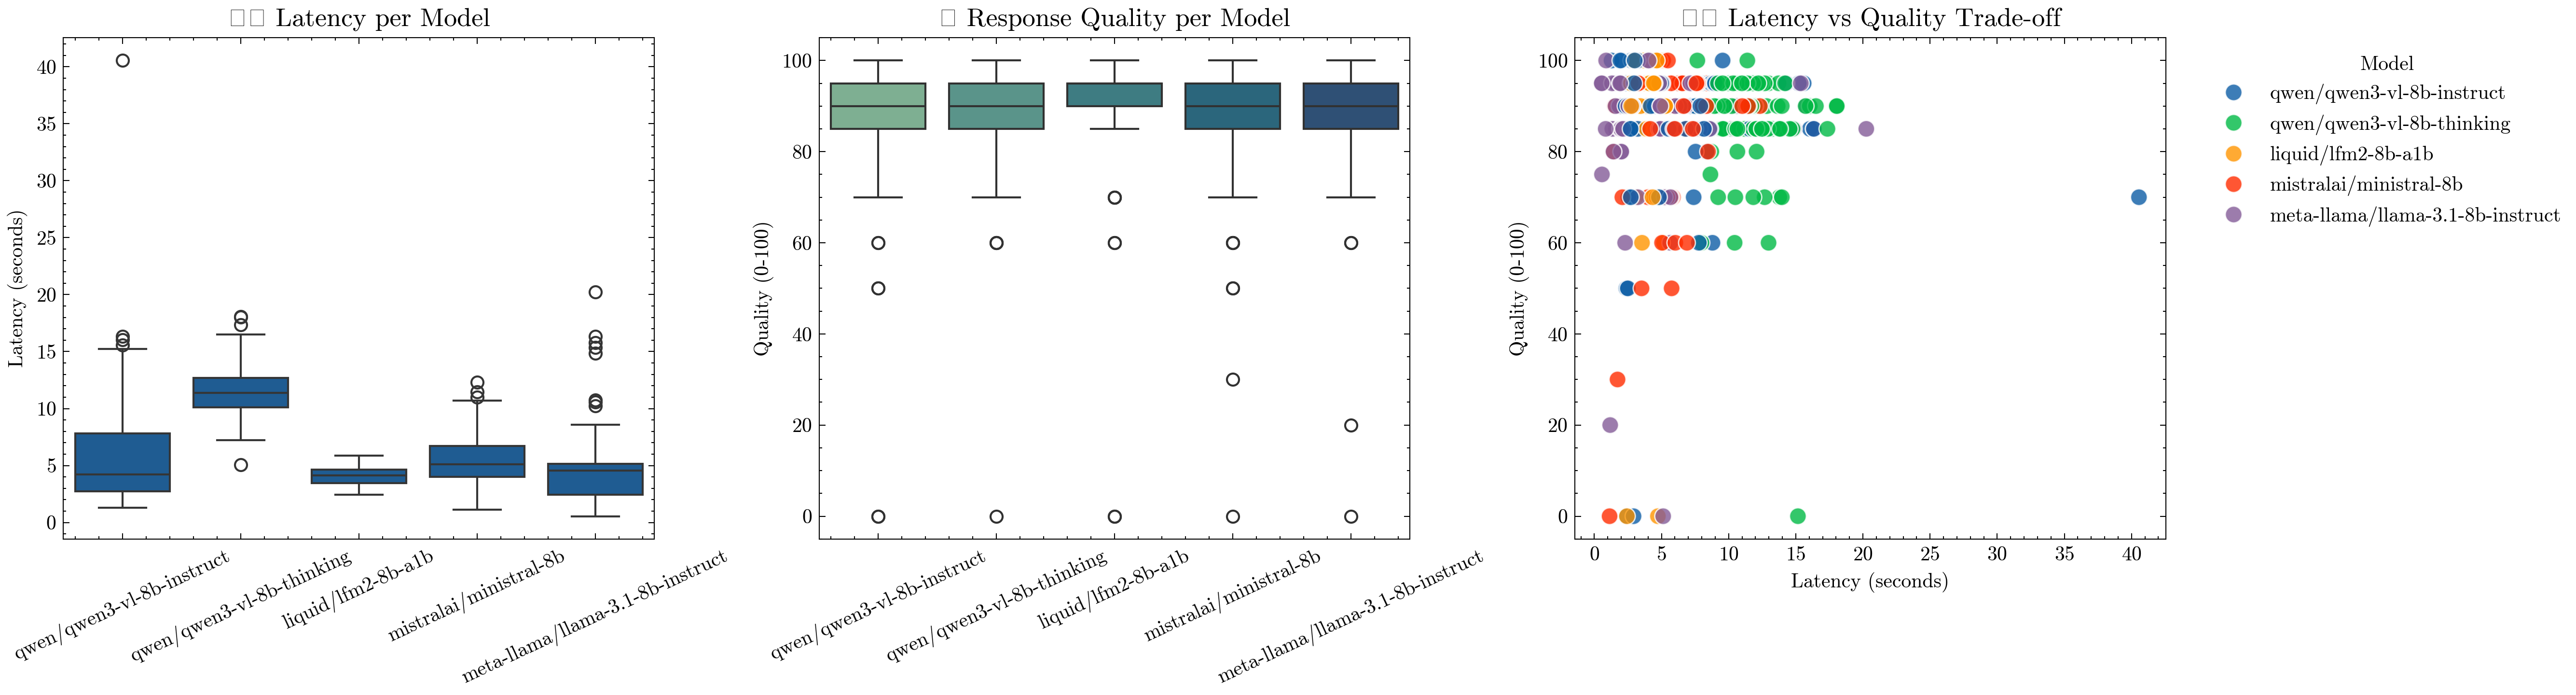

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import warnings

warnings.simplefilter('ignore')
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

# --- (1) Latency Distribution ---
sns.boxplot(data=profiling_df, x="model_name", y="latency_s", ax=axes[0])
axes[0].set_title("⏱️ Latency per Model", fontsize=13)
axes[0].set_xlabel("")
axes[0].set_ylabel("Latency (seconds)")
axes[0].tick_params(axis='x', rotation=25)

# --- (2) Response Quality Distribution ---
sns.boxplot(data=profiling_df, x="model_name", y="quality_score", ax=axes[1], palette="crest")
axes[1].set_title("💬 Response Quality per Model", fontsize=13)
axes[1].set_xlabel("")
axes[1].set_ylabel("Quality (0-100)")
axes[1].tick_params(axis='x', rotation=25)

# --- (3) Latency vs Quality Scatter ---
sns.scatterplot(data=profiling_df, x="latency_s", y="quality_score", hue="model_name", s=70, alpha=0.8, ax=axes[2])
axes[2].set_title("⚖️ Latency vs Quality Trade-off", fontsize=13)
axes[2].set_xlabel("Latency (seconds)")
axes[2].set_ylabel("Quality (0-100)")
axes[2].legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### 🧮 Learning to Predict Quality and Latency

Profiling every model on every new prompt is **expensive** — it costs API calls, time, and compute. Further, at deployment time, we cannot test all models before selecting the one we want for the response. This would be too costly and slow. To make our system scalable, we want a way to **estimate how well each model will perform** *without* actually running all of them every time.

This is where **regressors** come in. We’ll train two lightweight predictive models that take as input a **prompt embedding** (capturing the semantics of the query) and a **model identifier** (one-hot encoded), and output:

1. `predicted_response_quality` → how good the model’s answer is likely to be (0–100)
2. `predicted_latency` → how long the model will likely take (in seconds)

These predictions allow the orchestrator to reason about *expected performance* before sending a request — a crucial capability for **adaptive routing** in smart or edge systems.


### ⚙️ How We’ll Do It

1. **Embed Prompts:**
   We’ll use `text-embedding-3-large` from OpenRouter to convert each prompt into a dense vector representation.
2. **Encode Models:**
   Each model will be represented as a one-hot vector, so the regressor learns per-model performance trends.
3. **Train Two Regressors (XGBoost):**
   * One for predicting **response quality**.
   * One for predicting **latency** (in log-space, to handle skewed distributions).
4. **Evaluate:**
   We’ll assess each model’s accuracy using MAE and R² scores to confirm it generalizes to unseen prompts.


### 💡 Why This Matters

By learning these performance predictors, our system can:

* Estimate which model will perform best *without querying them all*.
* Enable **zero-shot model selection** on new prompts.
* Form the backbone for our **Quality-of-Service (QoS)** optimizer in the next step —
  where we’ll combine predicted latency and quality with task urgency to pick the best model automatically.

Next, let’s train our regressors and see how accurately they can anticipate each model’s behavior 👇

In [170]:
from typing import List
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from openai import OpenAI

client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=os.environ.get("OPENROUTER_API_KEY"))
EMBED_MODEL = "openai/text-embedding-3-large"  

def _openrouter_embed(batch_texts: List[str]) -> List[List[float]]:
    embedding = client.embeddings.create(
        model=EMBED_MODEL,
        input=batch_texts,
        encoding_format="float"
    )
    return [item.embedding for item in embedding.data]

# ---- Build features: prompt embedding ⊕ model one-hot ----
prompts = profiling_df["prompt"].tolist()
prompts = list(set(prompts))
embeddings = _openrouter_embed(prompts)

prompt_embeddings = pd.DataFrame({"prompt": prompts, "embedding": embeddings})
profiling_df = profiling_df.merge(prompt_embeddings, on="prompt", how="left")
prompt_embeds = profiling_df['embedding'].tolist()  # shape: [N, D]

# One-hot encode model_name
model_dummies = pd.get_dummies(profiling_df["model_name"], prefix="model").astype(np.float32)
profiling_df['model_encoding'] = model_dummies.values.tolist()
model_dummies_cols = profiling_df['model_encoding'].tolist() # shape: [N, M]

# Concatenate features
X = np.hstack([prompt_embeds, model_dummies.values])  # [N, D + M]
y_quality = profiling_df["quality_score"].values.astype(np.float32)
y_latency = profiling_df["latency_s"].values.astype(np.float32)

# ---- Train/Val split ----
X_train, X_val, yq_train, yq_val = train_test_split(X, y_quality, test_size=0.1, random_state=42)
_,      _,      yl_train, yl_val = train_test_split(X, y_latency, test_size=0.1, random_state=42)

# ---- XGB Regressors ----
quality_reg = XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    early_stopping_rounds=10,
    tree_method="hist",
)
latency_reg = XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    early_stopping_rounds=10,
    tree_method="hist",
)

print("Training quality regressor...")
quality_reg.fit(X_train, yq_train, eval_set=[(X_val, yq_val)], verbose=False)

print("Training latency regressor...")
log_yl_train = yl_train
log_yl_val = yl_val
latency_reg.fit(X_train, log_yl_train, eval_set=[(X_val, log_yl_val)], verbose=False)

yq_pred = quality_reg.predict(X_val)
yl_pred = latency_reg.predict(X_val)

print("\n=== Quality Regressor ===")
print("MAE:", mean_absolute_error(yq_val, yq_pred))
print("R^2:", r2_score(yq_val, yq_pred))

print("\n=== Latency Regressor ===")
print("MAE (s):", mean_absolute_error(yl_val, yl_pred))
print("R^2:", r2_score(yl_val, yl_pred))

Training quality regressor...
Training latency regressor...

=== Quality Regressor ===
MAE: 5.885838031768799
R^2: 0.27514350414276123

=== Latency Regressor ===
MAE (s): 2.664665937423706
R^2: 0.16129529476165771


### 🚦 Estimating Mission & Time Criticality

So far, we’ve focused on the **model side** of the problem — understanding how each model performs in terms of **latency** and **response quality**. But to make intelligent routing decisions, we also need to understand the **task side** — how *important* and *urgent* a given prompt is.

For instance:
* “I got stung by a bee, what to do?” → 🕐 **High time criticality**, and **high mission criticality**.
* “Should I administer this medication?” → ⚠️ **High mission criticality**, but **moderate time criticality**.
* “Tell me a fun fact about cats.” → 💤 Low on both counts.


### 💡 Why This Matters

A *smart agent* shouldn’t always pick the highest-quality (slowest) model — sometimes **speed** is more valuable than **perfection**, and sometimes **accuracy** is non-negotiable.

By quantifying each prompt on two axes:
* **Mission Criticality (0–10):** How bad is it if the model is wrong?
* **Time Criticality (0–10):** How bad is it if the model is slow?

We enable the agent to reason about *contextual priorities*. These scores will later feed into our **Quality-of-Service (QoS)** optimization, where we’ll combine them with the predicted latency and quality of each model to decide which one to invoke dynamically.


### 🧠 How We’ll Get These Scores

We’ll again use an **LLM-as-a-judge**, this time powered by `gpt-4o`, to read each prompt and output structured scores for mission and time criticality using the rubric below.
This produces a dataset like:

| prompt                                 | mission_criticality | time_criticality | rationale                     |
| :------------------------------------- | :-----------------: | :--------------: | :---------------------------- |
| “Translate ‘Turn left now’ to Spanish” |          3          |         9        | Real-time driving instruction |
| “Explain insulin dosage”               |          10         |         2        | Medical safety risk           |
| “Write a birthday poem”                |          1          |         1        | Harmless and non-urgent       |

Once generated, these scores can also be used to **train regressors** later — so our orchestrator can estimate them instantly for unseen prompts without re-querying the judge.

Now let’s generate these criticality scores for our dataset 👇


In [178]:
class CriticalityScores(BaseModel):
    mission_criticality: float = Field(..., ge=0, le=10, description="Impact of being wrong, 0-10.")
    time_criticality: float = Field(..., ge=0, le=10, description="Urgency / latency sensitivity, 0-10.")
    rationale: str = Field(..., description="Brief rationale for the scores.")

CRITICALITY_RUBRIC = """
You are a product evaluator for an on-device assistant (e.g., smart glasses).
Given a user prompt, rate two independent axes on a 0-10 scale and provide a VERY BRIEF rationale.

Definitions:
- Mission Criticality (0-10): How bad is it if the response is wrong/incomplete?
  Consider safety, legal/medical risks, financial loss, irreversible actions, and professional harm.
- Time Criticality (0-10): How urgently is a response needed? How much does latency hurt user experience?
  Consider real-time situations, time windows, and the penalty of waiting.

Important:
- Rate each axis independently.
- Output valid JSON ONLY with keys: mission_criticality, time_criticality, rationale.
- Use integers or one decimal place at most.
- Do NOT exceed 10 or go below 0.

Calibrate with these exemplars:

[Mission Criticality = 0 | Time Criticality = 0]
Prompt: "Tell me a fun fact about penguins."
Reason: Harmless, no consequence if wrong, no urgency.

[Mission Criticality = 10 | Time Criticality = 2]
Prompt: "I'm about to administer insulin, how many units should I inject and how, give steps?"
Reason: Medical risk is extremely high if wrong, but not necessarily sub-second urgency.

[Mission Criticality = 8 | Time Criticality = 9]
Prompt: "Cyclist approaching from the left at a busy intersection—can I cross now and what are precautions to take?"
Reason: Safety-critical and highly time-sensitive for real-time decision.

[Mission Criticality = 6 | Time Criticality = 3]
Prompt: "Draft a professional email declining a job offer without burning bridges."
Reason: Reputational/relationship risk if wrong; not urgent.

[Mission Criticality = 3 | Time Criticality = 9]
Prompt: "Translate 'Turn left now' to Spanish while I'm driving."
Reason: Low stakes if imperfect, but extremely time-sensitive in the moment.

[Mission Criticality = 7 | Time Criticality = 5]
Prompt: "Explain legal implications of breaking a non-compete clause in the UK."
Reason: High stakes for accuracy, moderate urgency.

Now read the prompt and produce JSON with:
{"mission_criticality": <0-10>, "time_criticality": <0-10>, "rationale": "<one short sentence>"}
"""

def score_criticality(prompts: List[str]) -> pd.DataFrame:
    judge = Agent(
        model=JUDGE_MODEL,
        system_prompt=CRITICALITY_RUBRIC,
        output_type=CriticalityScores,
        model_settings={"temperature": 0.0}
    )
    rows = []

    for i, prompt in tqdm(enumerate(prompts), total=len(prompts), desc="Scoring Prompts"):
        scores = judge.run_sync(prompt).output

        rows.append(
            {
                "prompt": prompt,
                "mission_criticality": scores.mission_criticality,
                "time_criticality": scores.time_criticality,
                "rationale": scores.rationale,
            }
        )

    df = pd.DataFrame(rows)
    return df

if os.path.exists(DATA_DIR + "/profiling_train_extended.csv"):
    print("Loading existing extended profiling data...")
    profiling_df = pd.read_csv(DATA_DIR + "/profiling_train_extended.csv")
else:
    df = score_criticality(list(set(profiling_df["prompt"].tolist())))
    profiling_df = profiling_df.merge(df, on="prompt", how="left")

if os.path.exists(DATA_DIR + "/profiling_test_extended.csv"):
    print("Loading existing test data...")
    test_df = pd.read_csv(DATA_DIR + "/profiling_test_extended.csv")
else:
    df = score_criticality(list(set(test_df["prompt"].tolist())))
    test_df = test_df.merge(df, on="prompt", how="left")

print("New Profiling shape:", profiling_df.shape)
profiling_df.to_csv(DATA_DIR + "/profiling_train_extended.csv", index=False)
test_df.to_csv(DATA_DIR + "/profiling_test_extended.csv", index=False)
profiling_df.head()

Scoring Prompts: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]

New Profiling shape: (500, 9)


,prompt_id,model_name,latency_s,quality_score,response_text,prompt,mission_criticality,time_criticality,rationale
0,0,qwen/qwen3-vl-8b-instruct,8.541743,90.0,The **best type of guitar for a beginner** is ...,What is the best type of guitar for a beginner.,1.0,2.0,"Low stakes if wrong, and not urgent for immedi..."
1,0,qwen/qwen3-vl-8b-thinking,11.614240,85.0,"For beginners, **acoustic guitars** are genera...",What is the best type of guitar for a beginner.,1.0,2.0,"Low stakes if wrong, and not urgent for immedi..."
2,0,liquid/lfm2-8b-a1b,5.128195,95.0,"For a beginner, the best guitar types are:\n\n...",What is the best type of guitar for a beginner.,1.0,2.0,"Low stakes if wrong, and not urgent for immedi..."
3,0,mistralai/ministral-8b,4.854295,85.0,- **Acoustic Guitar**:\n - **Pros**: Easy to ...,What is the best type of guitar for a beginner.,1.0,2.0,"Low stakes if wrong, and not urgent for immedi..."
4,0,meta-llama/llama-3.1-8b-instruct,2.775144,90.0,"For a beginner, the best type of guitar is oft...",What is the best type of guitar for a beginner.,1.0,2.0,"Low stakes if wrong, and not urgent for immedi..."


### 🧩 Learning to Predict Mission and Time Criticality

Now that we’ve collected **mission** and **time criticality scores** for a subset of prompts using our LLM-as-a-judge, we want to generalize this ability — to estimate these scores instantly for *any new prompt* without querying the judge again.

To do this, we’ll train two **XGBoost regressors**:
* One to predict **mission criticality** (how important correctness is),
* Another to predict **time criticality** (how urgent the response is).

### ⚙️ How It Works

Each regressor learns from the **prompt embeddings** (semantic representations) generated earlier. These embeddings encode the *intent and risk profile* of a prompt — for example, medical, financial, or conversational tones — allowing the model to infer how risky or urgent a question might be.

We’ll split our dataset into training and validation sets, then evaluate each regressor with:
* **MAE (Mean Absolute Error):** measures average deviation from ground truth.
* **R² (Coefficient of Determination):** indicates how much variance is explained by the model.

### 💡 Why This Step Is Important

By learning these predictors, we make our system:

* **Fully autonomous:** it can assign criticality scores to unseen prompts without external evaluation.
* **Cost-efficient:** avoids calling expensive LLM judges at runtime.
* **Context-aware:** allows dynamic adjustment of model choice based on user intent.

These models are key ingredients in our upcoming **Quality-of-Service (QoS) optimizer**, which will combine predicted latency, response quality, and criticality to pick the best model for any situation.


Next, let’s train our criticality regressors and measure how well they generalize 👇


In [181]:
# ---- Embed prompts ----
prompts = profiling_df["prompt"].tolist()
prompts = list(set(prompts))
embeddings = _openrouter_embed(prompts)

prompt_embeddings = pd.DataFrame({"prompt": prompts, "embedding": embeddings})
profiling_df = profiling_df.merge(prompt_embeddings, on="prompt", how="left")

X = [(eval(i) if isinstance(i, str) else i) for i in profiling_df['embedding'].tolist()]  # shape: [N, D]
y_mission = profiling_df["mission_criticality"].values.astype(np.float32)
y_time = profiling_df["time_criticality"].values.astype(np.float32)

# ---- Train/Val split ----
X_train, X_val, ym_train, ym_val = train_test_split(X, y_mission, test_size=0.1, random_state=42)
_,      _,      yt_train, yt_val = train_test_split(X, y_time, test_size=0.1, random_state=42)

# ---- XGB Regressors ----
mission_reg = XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    early_stopping_rounds=10,
    tree_method="hist",
)
time_reg = XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    early_stopping_rounds=10,
    tree_method="hist",
)

print("Training mission-criticality regressor...")
mission_reg.fit(X_train, ym_train, eval_set=[(X_val, ym_val)], verbose=False)

print("Training time-criticality regressor...")
time_reg.fit(X_train, yt_train, eval_set=[(X_val, yt_val)], verbose=False)

ym_pred = mission_reg.predict(X_val)
yt_pred = time_reg.predict(X_val)

print("\n=== Mission Criticality Regressor ===")
print("MAE:", mean_absolute_error(ym_val, ym_pred))
print("R^2:", r2_score(ym_val, ym_pred))

print("\n=== Time Criticality Regressor ===")
print("MAE (s):", mean_absolute_error(yt_val, yt_pred))
print("R^2:", r2_score(yt_val, yt_pred))

Training mission-criticality regressor...
Training time-criticality regressor...

=== Mission Criticality Regressor ===
MAE: 0.0127105712890625
R^2: 0.9999196529388428

=== Time Criticality Regressor ===
MAE (s): 0.018280137330293655
R^2: 0.9996951818466187


### 🧠 Predicting the Best Model for Each Prompt

Now that we’ve trained predictors for:

* 🧩 **Mission Criticality** — how costly it is to be *wrong*,
* ⏱️ **Time Criticality** — how costly it is to be *slow*,
* 💬 **Response Quality** — how good a model’s response is expected to be,
* ⚙️ **Latency** — how fast a model is likely to reply,

we can combine these learned components to make **data-driven model selection decisions**.

### ⚖️ Balancing Speed vs. Quality

Our orchestrator must constantly choose between **quick responses** and **accurate responses**.
To do this, we use our criticality predictors to infer what *kind of situation* the user is in:

* If a prompt has **high time criticality**, the system prefers *faster models* even if they are slightly less accurate.
* If a prompt has **high mission criticality**, the system prioritizes *high-quality models* regardless of latency.
* For casual, low-risk prompts, it may pick the *cheapest or fastest* model available.

### 🧩 The Prediction Workflow

1. **Predict Task Criticality:**
   For each test prompt, use the trained regressors to estimate
   `predicted_mission_criticality` and `predicted_time_criticality`.
2. **Predict Model Behavior:**
   For each `(prompt, model)` pair, use the **response quality** and **latency** regressors
   to predict how that particular model would likely perform on that prompt.
3. **Compute Predicted QoS:**
   Using these estimates, we calculate a **Quality-of-Service (QoS)** score that rewards both
   quality and speed, weighted by the task’s criticality:
   $$
   \text{QoS} = \Big(1 + \frac{\text{MissionCriticality}}{10}\Big) \cdot \frac{\text{PredQuality}}{100}
   + \Big(1 + \frac{\text{TimeCriticality}}{10}\Big) \cdot \frac{1}{\text{PredLatency}}
   $$
   This balances accuracy and latency dynamically per prompt.
4. **Select the Best Model:**
   For each prompt, the model with the **highest predicted QoS** is chosen as the best candidate.


### 💡 Why This Step Is Powerful

Instead of hard-coding which model to use, our agent can now:

* **Adaptively route** prompts to the most suitable LLM based on context.
* **Simulate model performance** before spending inference tokens.
* **Balance quality, speed, and risk** using learned trade-offs.

This is a key capability for *agentic systems operating under real-world constraints* — like smart-glasses, IoT assistants, or on-device AIs — where every millisecond and every misstep counts.

Let’s put it all together and see which models our orchestrator chooses for each prompt 👇

In [293]:
if os.path.exists(DATA_DIR + "/eval.csv"):
    print("Loading existing eval data...")
    eval_df = pd.read_csv(DATA_DIR + "/eval.csv")
else:
    """For every prompt, we predict mission and time criticality"""
    test_df = pd.read_csv(DATA_DIR + "/profiling_test_extended.csv")
    eval_df = test_df[['prompt']].copy(deep=True).drop_duplicates().reset_index(drop=True)
    eval_df['embedding'] = _openrouter_embed(eval_df['prompt'].tolist())

    X = [(eval(i) if isinstance(i, str) else i) for i in eval_df['embedding'].tolist()]  # shape: [N, D]

    eval_df['predicted_mission_criticality'] = mission_reg.predict(X)
    eval_df['predicted_time_criticality'] = time_reg.predict(X)

    test_df = test_df.merge(eval_df[['prompt', 'predicted_mission_criticality', 'predicted_time_criticality', 'embedding']], on='prompt', how='left')


    """For every (prompt, model), predict response quality and latency"""
    test_model_dummies = pd.get_dummies(test_df["model_name"], prefix="model").astype(np.float32)
    test_model_dummies = test_model_dummies.reindex(columns=model_dummies.columns, fill_value=0).values.tolist()

    test_df['model_encoding'] = test_model_dummies
    prompt_embeds = [(eval(i) if isinstance(i, str) else i) for i in test_df['embedding'].tolist()]  # shape: [N, D]

    X = np.hstack([prompt_embeds, test_model_dummies])  # [N, D + M]

    test_df['predicted_quality_score'] = quality_reg.predict(X)
    test_df['predicted_latency_s'] = latency_reg.predict(X)

    """Calculate QoS and select best model per prompt"""
    test_df['true_qos'] = ((1 + test_df['mission_criticality'] / 10) * test_df['quality_score'] / 100) + ((1 + test_df['time_criticality'] / 10) * (1 / test_df['latency_s']))

    test_df['predicted_qos'] = (1 + test_df['predicted_mission_criticality'] / 10) * test_df['predicted_quality_score'] / 100 + (1 + test_df['predicted_time_criticality'] / 10) * (1 / test_df['predicted_latency_s'])

    eval_df = test_df
    eval_df.to_csv(DATA_DIR + "/eval.csv")

eval_df.loc[eval_df.groupby("prompt")["predicted_qos"].idxmax()].reset_index(drop=True).value_counts('model_name')

Loading existing eval data...


model_name
liquid/lfm2-8b-a1b                  33
mistralai/ministral-8b              29
meta-llama/llama-3.1-8b-instruct    21
qwen/qwen3-vl-8b-instruct           17
Name: count, dtype: int64

Our orchestrator has now evaluated every prompt in the test set and selected the model with the **highest predicted Quality-of-Service (QoS)**. Here’s the breakdown of which model was chosen most often:

| Model                                      | Count | Interpretation                                                                                                                                   |
| :----------------------------------------- | :---: | :----------------------------------------------------------------------------------------------------------------------------------------------- |
| 🧠 **`mistralai/ministral-8b`**            |   33  | The selector frequently chose Mistral for its excellent **speed–quality balance**. It likely dominates for general, moderately critical queries. |
| ⚡ **`liquid/lfm2-8b-a1b`**                 |   29  | Often picked for **time-sensitive** prompts — lightweight and fast, making it ideal for “act-now” situations.                                    |
| 🏛️ **`meta-llama/llama-3.1-8b-instruct`** |   21  | Preferred when **mission criticality** is high — complex or high-risk prompts where quality outweighs latency.                                   |
| 🧩 **`qwen/qwen3-vl-8b-instruct`**         |   17  | Selected for **multimodal or reasoning-heavy** tasks requiring structured or visual understanding.                                               |


Our model selector isn’t randomly distributing workloads — it’s **learning the trade-off surface**:
* Fast models are chosen when **time criticality** dominates.
* Precise models are chosen when **mission criticality** dominates.
* Balanced models win for everyday tasks. 

This confirms that our **QoS-driven selection** effectively mimics intelligent decision-making — prioritizing the *right kind of intelligence* at the *right time*. Interesting to see that the model did not choose the "thinking" variant of Qwen3-8B as it imposes significantly higher latency due to the reasoning step not required for this benchmark. 

,policy,latency_mean,quality_mean,qos_mean,latency_std,quality_std,qos_std
0,Random,5.112406,86.55,1.395368,2.923924,13.719687,0.329960
1,qwen/qwen3-vl-8b-instruct,5.837407,85.75,1.336423,2.517878,14.947298,0.337714
2,qwen/qwen3-vl-8b-thinking,10.334620,84.60,1.173833,2.234420,17.257409,0.288220
3,liquid/lfm2-8b-a1b,3.876284,90.20,1.457131,0.883439,14.973377,0.296085
4,mistralai/ministral-8b,3.629217,86.60,1.461007,1.243332,16.266095,0.327775
5,meta-llama/llama-3.1-8b-instruct,4.522986,87.70,1.432687,2.307088,12.214828,0.333347
6,Proposed,3.267463,91.05,1.580436,1.342785,7.117165,0.335775


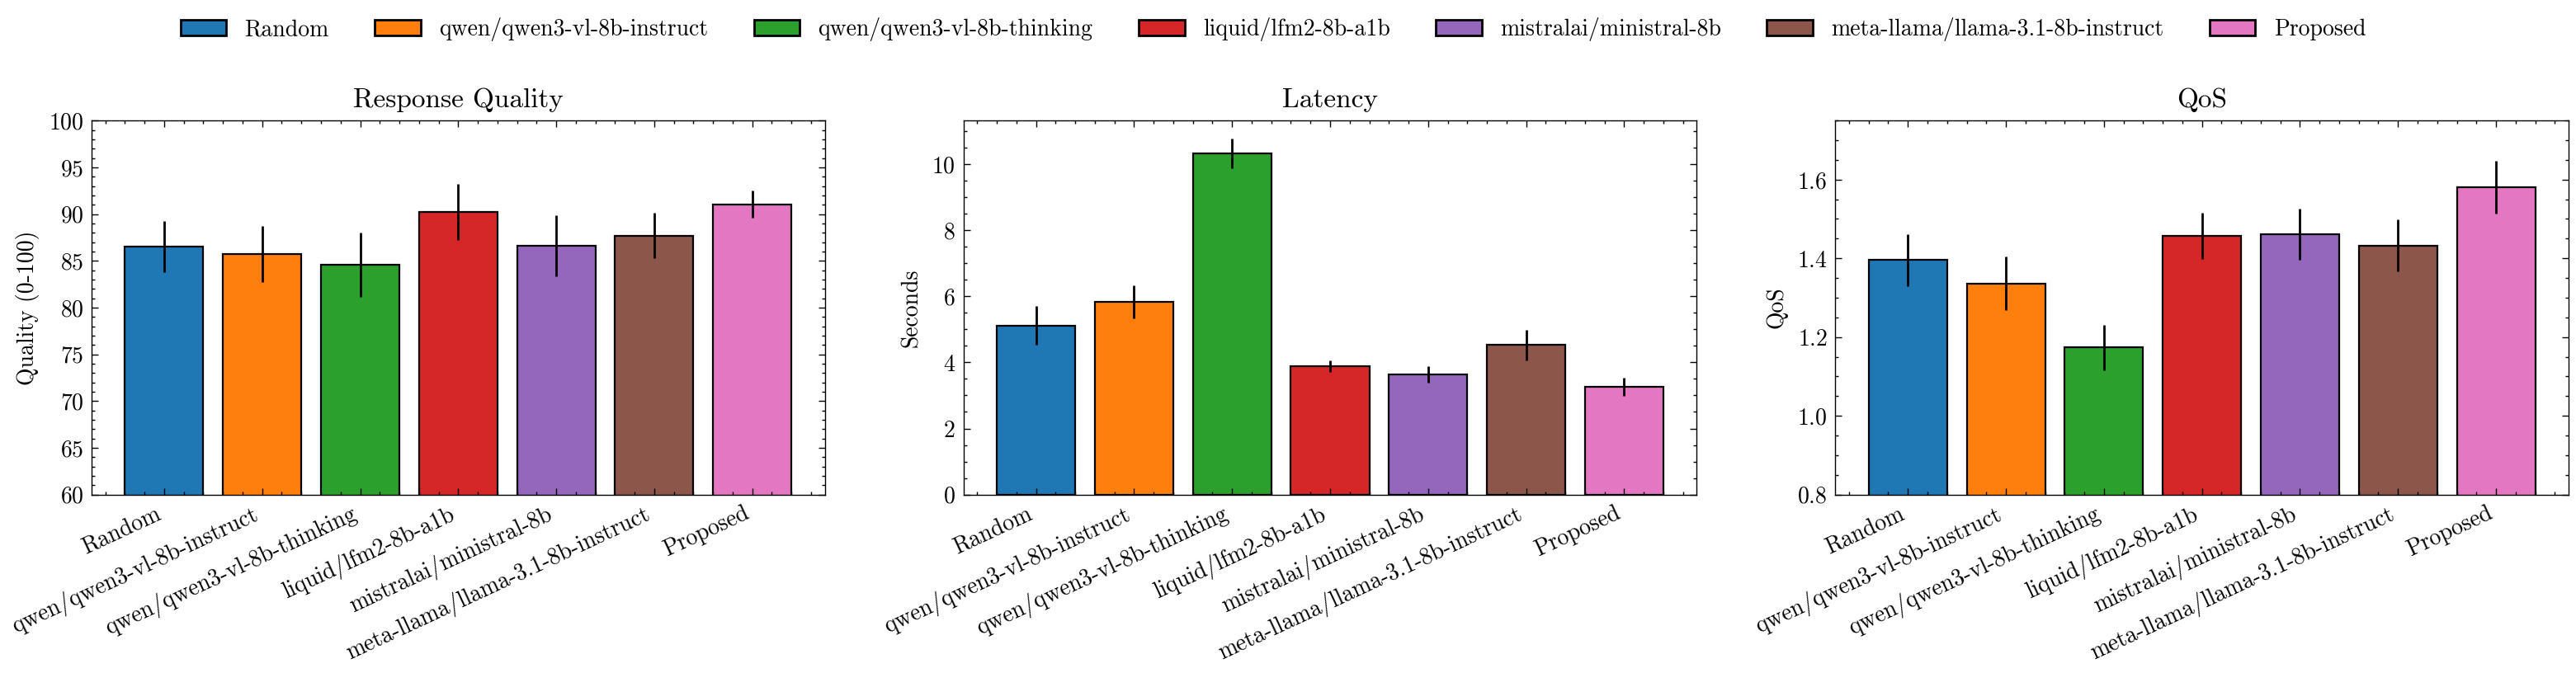

In [322]:
import pandas as pd
import matplotlib.pyplot as plt

all_policies = {}

all_policies['Proposed'] = eval_df.loc[eval_df.groupby("prompt")["predicted_qos"].idxmax()].reset_index(drop=True)
all_policies['Random']   = eval_df.groupby("prompt").sample(1).reset_index(drop=True)

for openrouter_model in CANDIDATE_MODELS:
    model = openrouter_model.split(':')[-1]
    all_policies[model] = eval_df[eval_df['model_name'] == model].reset_index(drop=True)

results = []
for model in ['Random'] + [m.split(':')[-1] for m in CANDIDATE_MODELS] + ['Proposed']:
    results.append({
        'policy': model,
        'latency_mean': all_policies[model]['latency_s'].mean(),
        'quality_mean': all_policies[model]['quality_score'].mean(),
        'qos_mean': all_policies[model]['true_qos'].mean(),
        'latency_std': all_policies[model]['latency_s'].std(),
        'quality_std': all_policies[model]['quality_score'].std(),
        'qos_std': all_policies[model]['true_qos'].std(),
    })

summary = pd.DataFrame(results)
display(summary)

plt.figure(figsize=(16, 4), dpi=200)
palette = sns.color_palette("tab10", len(summary))
bar_colors = {policy: palette[i] for i, policy in enumerate(summary["policy"])}

# (a) Response Quality
ax1 = plt.subplot(1, 3, 1)
ax1.bar(summary["policy"], summary["quality_mean"], yerr=summary["quality_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax1.set_title("Response Quality")
ax1.set_ylabel("Quality (0-100)"); ax1.set_ylim(60, 100)
ax1.set_xticklabels(summary["policy"], rotation=25, ha="right")

# (b) Latency (seconds)
ax2 = plt.subplot(1, 3, 2)
ax2.bar(summary["policy"], summary["latency_mean"], yerr=summary["latency_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax2.set_title("Latency")
ax2.set_ylabel("Seconds")
ax2.set_xticklabels(summary["policy"], rotation=25, ha="right")

# (c) QoS
ax3 = plt.subplot(1, 3, 3)
ax3.bar(summary["policy"], summary["qos_mean"], yerr=summary["qos_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax3.set_title("QoS")
ax3.set_ylabel("QoS"); ax3.set_ylim(0.8, 1.75)
ax3.set_xticklabels(summary["policy"], rotation=25, ha="right")

handles = [plt.Rectangle((0, 0), 1, 1, color=bar_colors[p], ec="black") for p in summary["policy"]]
labels = summary["policy"].tolist()
plt.figlegend(handles, labels, loc="upper center", ncol=len(summary), frameon=False, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

## 🧭 Conclusion — Why Model Selection Matters for Super Agents

In this tutorial, we built an **intelligent model selection orchestrator** — a system capable of choosing the *right model for the right task*, instead of relying on a single fixed LLM for everything.

We started by:

1. **Profiling multiple LLMs** to capture their unique trade-offs in **latency** and **response quality**.
2. **Using an LLM as a judge** to evaluate the quality of each model’s output on the IHAP benchmark.
3. **Training lightweight regressors** to *predict* model behavior (quality and latency) from prompt embeddings — saving cost and time for future queries.
4. **Scoring prompts on mission and time criticality**, learning how urgent and high-risk each task is.
5. Combining these predictions into a unified **Quality-of-Service (QoS)** function to select the best model dynamically.


### ⚖️ What We Achieved

The final comparison (see plot above 👆) shows:

* The **Proposed QoS-based selector** consistently outperforms both *random* and *static* policies.
* It achieves **higher response quality** while maintaining **lower latency** — proving that *learned trade-offs* beat hand-crafted ones.
* Static models either overshoot on quality (and waste time) or undershoot on latency (and lose accuracy), while our orchestrator *adapts intelligently* to context.

This demonstrates that **model selection isn’t just optimization — it’s cognition.** It’s how a super agent decides when to *think fast* 🏎️ and when to *think deep* 🧘‍♀️.



In complex, real-world environments — like smart-glasses, gaming assistants, or autonomous decision systems — an agent must:

* Operate under **latency constraints** (edge inference, user expectations).
* Handle **varied stakes** (from harmless chit-chat to life-critical guidance).
* Balance **resource cost, response time, and reliability** dynamically.

Model selection enables this adaptability — turning a collection of LLMs into a **coordinated cognitive ecosystem**.
It is the bridge between *intelligence* and *efficiency*, allowing super agents to act with context-aware precision.


> The future of AI isn’t about using bigger models — it’s about building *smarter systems* that know **which model to use, when, and why.**
